# **Sistema Predictivo para Diagnosticar la Enfermedad de Parkinson Basado en Pruebas del Habla.**

Juan Pablo Gómez Restrepo,  juan.gomez125@udea.edu, Estudiante de ingeniería



Sebastian Gómez Molinasebastian, gomez19@udea.edu.co, Estudiante de ingeniería

## **Metodos implementados**

In [ ]:
!pip install mlxtend

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 25.0 MB/s 


In [ ]:
!pip install joblib

## IMPORTAR LIBRERIAS

In [ ]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import time
from scipy.spatial import distance
from scipy import stats
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.metrics import accuracy
import operator
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from mlxtend.feature_extraction import PrincipalComponentAnalysis as PCA
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from mlxtend.preprocessing import standardize
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

### **Cargar Base De Datos Y Conjunto De Muestras De Entrenamiento**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/train_data.txt', header=None)
test = pd.read_csv('/test_data.txt', header=None)

In [ ]:
#Conjunto de muestras de entrenamiento
Xtrain = train.iloc[0:1040,1:26].to_numpy()
Ytrain = train.iloc[0:1040,28].to_numpy()

Xtest = test.iloc[0:168,1:26].to_numpy()
Ytest = test.iloc[0:168,27].to_numpy()

In [ ]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

### ***Analisis Driscriminante Cuadratico***

In [ ]:
def error(Y_lest, Y):
    error = 0
    for ye, y in zip(Y_lest, Y):
        if ye != y:
            error += 1
    error = error/np.size(Y)
    return error

tiempo_i = time.time()

#Estandarizamos la base de datos
# Use Max - Min
scaler = MinMaxScaler()
scaler.fit(Xtrain)
X = scaler.transform(Xtrain)

Errores = np.ones(1000)
j = 0
kf = KFold(n_splits=1000)

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Ytrain[train_index], Ytrain[test_index]   
    
    #Funcion d gaussiana de naive bayes
    fdg = GaussianNB().fit(X_train, y_train)
    GaussianNB()
    y_estdg = fdg.predict(X_test)
    
    Errores[j] = error(y_estdg, y_test)
    j+=1
    
print("\nError de validación: " + str(np.mean(Errores)) + " +/- " + str(np.std(Errores)))
print ('\nTiempo total de ejecución: ' + str(time.time()-tiempo_i) + ' segundos.')



Error de validación: 0.408 +/- 0.48737665106157885

Tiempo total de ejecución: 1.086411476135254 segundos.


### ***Ventana de Parzen***

In [ ]:
def dist_euclidiana(x1, x2):
    
    dist = distance.euclidean(x1, x2)
    
    return dist

In [ ]:
# Error cuadrático medio para los problemas de regresión
def ECM(Y_est,Y):
    N = np.size(Y)
    Y = 100*Y    #Analice la variable de salida de la base de datos y observe porque se multiplica por 100
    Y_est = 100*np.asarray(Y_est)
    ecm = sum((Y_est - Y)**2)/(2*N)
    
    return ecm

#Para calcular el error en los problemas de clasificación
def error(Y_lest, Y):
    error = 0
    for ye, y in zip(Y_lest, Y):
        if ye != y:
            error += 1
    
    error = error/np.size(Y)
    
    return error

tiempo_i = time.time()

def KNN(X_train, Y_train, X_val, Y_val, knn):
    
    k = knn    #Parámetro k que equivale al número de vecinos a tener en cuenta para resolver el problema de
               #predicción de la variable de salida
    
    Y_est = []
    
    for x1 in X_val:
        distances = dict()
        for x2, y2 in zip(X_train, Y_train):
            distances.update({dist_euclidiana(x1,x2): y2})
    
        #k vecinos más cercanos cercanos
        vecinos = sorted(distances.items(), key=operator.itemgetter(0))
        #print vecinos
          
        y_vecinos = []
        for i in vecinos[:knn]:
            y_vecinos.append(i[1])
        

        #sf = select_features(model,10,False,True)
        mode = stats.mode(y_vecinos, axis=None)
        y_est = mode[0]
        Y_est.append(y_est)
    
    print ("Modelo KNN para clasificación\n\n"+"El Error de clasificación del modelo con " + str(k) + " vecinos es = " + str(error(Y_est,Y_val))+"\n")
    print ('\nTiempo total de ejecución: ' + str(time.time()-tiempo_i) + ' segundos.')

In [ ]:
KNN(Xtrain,Ytrain,Xtest,Ytest,120)

Modelo KNN para clasificación

El Error de clasificación del modelo con 120 vecinos es = 0.06547619047619048


Tiempo total de ejecución: 4.035804986953735 segundos.


<table>
<tr>
<td>Error de clasificacion</td>
<td>Numero de vecinos</td>
</tr>
<tr>
<td>0.24404761904761904 </td>
<td>50</td>
</tr>
<tr>
<td>0.19642857142857142 </td>
<td>70</td>
</tr>
<tr>
<td>0.16666666666666666 </td>
<td>90</td>
</tr>
<tr>
<td>0.14285714285714285 </td>
<td>100</td>
</tr>
<tr>
<td>0.06547619047619048 </td>
<td>120</td>
</tr>
</table>

### ***Gradiente Boosting Tree***

In [ ]:
def metrics(y_test, y_pred):
    y_test = np.asarray(y_test)
    y_pred = np.asarray(y_pred)


    TP,TN,FP,FN = 0,0,0,0
    for t,p in zip(y_test,y_pred):
        if t==1:
            if p>=0.5: #yp==1:
                TP+=1
            else:
                FN+=1
        else:
            if p>=0.5: #yp==1:
                FP+=1
            else:
                TN+=1
    
    recall = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = (2*recall*prec)/(recall+prec)
    acc = (TP+TN)/(TP+FP+FN+TN)
    esp = TN/(TN+FP)

    return acc


Epoch 1/10
9/9 [==============================] - 1s 23ms/step - loss: 37.7839 - accuracy: 0.5000 - val_loss: 28.6009 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 0s 7ms/step - loss: 25.2442 - accuracy: 0.5000 - val_loss: 16.8648 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 0s 7ms/step - loss: 13.0553 - accuracy: 0.4952 - val_loss: 5.6109 - val_accuracy: 0.4362
Epoch 4/10
9/9 [==============================] - 0s 7ms/step - loss: 6.2812 - accuracy: 0.4667 - val_loss: 6.5212 - val_accuracy: 0.4787
Epoch 5/10
9/9 [==============================] - 0s 7ms/step - loss: 7.0845 - accuracy: 0.4751 - val_loss: 6.1336 - val_accuracy: 0.4787
Epoch 6/10
9/9 [==============================] - 0s 7ms/step - loss: 5.8677 - accuracy: 0.4679 - val_loss: 4.2087 - val_accuracy: 0.4468
Epoch 7/10
9/9 [==============================] - 0s 7ms/step - loss: 4.9498 - accuracy: 0.4561 - val_loss: 3.9591 - val_accuracy: 0.4787
Epoch 8/10
9/9 [============

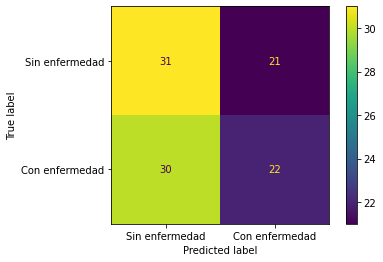

In [ ]:
#Error cuadrático medio (para problemas de regresión)
def ECM(Y_real,Y_est):
    N = np.size(Y_real)
    ecm = sum((Y_est - Y_real)**2)/N
    return ecm

#Para calcular el costo computacional
tiempo_i = time.time()

#Complete el código para crear la red neuronal artificial.
#Para la configuración de la red observe la tabla de más abajo.
#Recuerde que debe usar la función identidad en la capa de salida (linear).
#Para la capa oculta puede use relu.

model = Sequential()
model.add(Dense(20, activation='relu',input_dim=25)) #se asignan 20 neuronas en la capa intermedia
model.add(Dense(1, activation='sigmoid')) #se pone 1 neurona de salida dado que el problema es biclase

#Implemetamos la metodología de validación cross validation con 10 folds

Errores = np.ones(10)
j = 0
kf = StratifiedKFold(n_splits=10)

for train_index, test_index in kf.split(Xtrain, Ytrain):
    X_train, X_test = Xtrain[train_index], Xtrain[test_index]
    y_train, y_test = Ytrain[train_index], Ytrain[test_index]

    #Complete el código
    #Use el optimizador Adam
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    #sf = select_features(model,10,False,True)
    
    # Complete el código para entrenar el modelo
    model.fit(X_train, y_train, epochs=10, batch_size=100, validation_split=0.1)

    #Complete el código aquí
    # Validación del modelo
    y_pred = (model.predict(X_test,batch_size=32) > 0.5).astype('int32').T[0]

    Errores[j] = metrics(y_test, y_pred)
    j+=1
    
target_names = ['Sin enfermedad', 'Con enfermedad']
print("\nError de validación: " + str(np.mean(Errores)) + " +/- " + str(np.std(Errores)))
print ("\n\nTiempo total de ejecución: " + str(time.time()-tiempo_i) + " segundos.")
print("\n")
print(classification_report(y_test,y_pred, target_names=target_names))
print("\nmatriz de confusión: \n" )
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()

In [ ]:
y_test

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

<table>
<tr>
<td># Epocas</td>
<td># Neuronas en primera capa</td>
<td># Neuronas en segunda capa</td>
<td>Error de validacion</td>
<td>std</td>
<td>tiempo de ejecucion</td>
</tr>
<tr>
<td>10</td>
<td>20</td>
<td>30</td>
<td>0.6105769230769231 </td>
<td>0.048887399303408324</td>
<td>16.099786520004272</td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
<td>0.19642857142857142 </td>
<td>70</td>
<td>50</td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
<td>0.16666666666666666 </td>
<td>90</td>
<td>50</td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
<td>0.14285714285714285 </td>
<td>100</td>
<td>50</td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
<td>0.06547619047619048 </td>
<td>120</td>
<td>50</td>
</tr>
</table>

### ***Redes de Neuronalas Artificiales***

In [ ]:
def class_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):
        if y_e != y_r:
            err += 1

    return "accuracy: " + str(1-(err/np.size(y_est)))

In [ ]:
tiempo_i = time.time()

kf = KFold(n_splits=10)

Errores = np.zeros(10)

for B in range(1,10,2):
      
    Errores = np.zeros(10)
    j = 0
    #Aplicando la metodología de validación
      
    for train_index, test_index in kf.split(Xtrain):
          
        #Complete el código para tomar las muestras de entrenamiento y validación usando
        #train_index y test_index 

        X_train, X_test = Xtrain[train_index], Xtrain[test_index]
        y_train, y_test = Ytrain[train_index], Ytrain[test_index]
          
        #Complete el código aquí creado el modelo Random Forest 
        #ara clasificar y entrenandolo solo con las muestras de entrenamiento 
          
        RF = RandomForestClassifier(n_estimators=B)
        
        #sf = select_features(model,10,False,True)
        
        #entrenamiento del modelo
        RF.fit(X_train, y_train)
          
        #Complete el código aquí prediciendo la clase para las muestras de validación de la base de datos
        Y_est = RF.predict(X_test)

        Errores[j] = classification_error(Y_est, y_test)
        j += 1

    print('\nResultado de clasificación con ', B, 'árboles:')
    print ("accuracy: " + str(1-np.mean(Errores)))
    print ('\nTiempo total de ejecución: ' + str(time.time()-tiempo_i) + ' segundos.')



Resultado de clasificación con  1 árboles:
accuracy: 0.5817307692307693

Tiempo total de ejecución: 0.08576798439025879 segundos.

Resultado de clasificación con  3 árboles:
accuracy: 0.6365384615384615

Tiempo total de ejecución: 0.26429104804992676 segundos.

Resultado de clasificación con  5 árboles:
accuracy: 0.6653846153846154

Tiempo total de ejecución: 0.5473930835723877 segundos.

Resultado de clasificación con  7 árboles:
accuracy: 0.6538461538461539

Tiempo total de ejecución: 0.9448225498199463 segundos.

Resultado de clasificación con  9 árboles:
accuracy: 0.6375

Tiempo total de ejecución: 1.3957421779632568 segundos.


<table>
<tr>
<td>Numero de árboles</td>
<td>accuaracy</td>
</tr>
<tr>
<td>0.4538461538461538 </td>
<td>1</td>
</tr>
<tr>
<td>0.4721153846153846 </td>
<td>3</td>
</tr>
<tr>
<td>0.4375 </td>
<td>5</td>
</tr>
<tr>
<td>0.4375000000000001 </td>
<td>7</td>
</tr>
<tr>
<td>0.40865384615384615 </td>
<td>9</td>
</tr>
</table>

### ***Maquinas de Soporte Vectorial***

In [ ]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

C_list = [0.1,1,10,100]
gamma_list = [0.0001, 0.001, 0.01, 0.1]

for c in C_list:
    for g in gamma_list:

#Para calcular el costo computacional

        tiempo_i = time.time()

#Complete el código para crear el clasificador SVM. Tenga en cuenta que el problema es multiclase. 
#Consulte como lo puede tratar con la SVM.
#Use un kernel rbf con una malla de valores así: C en {0.1,1,10,100} y gamma en {0.0001,0.01, 0.1}

        clf = svm.SVC(C = c, gamma = g, kernel='rbf', decision_function_shape = 'ovr')

#Implemetamos la metodología de validación cross validation con 10 folds

        Errores = np.ones(10)
        j = 0
        kf = KFold(n_splits=10)

        for train_index, test_index in kf.split(Xtrain):
            
            #ex = extract_features('pca',19)
            
            #ex = ex.fit(X)
            
            #X_ex = ex.transform(X)

            X_train, X_test = Xtrain[train_index], Xtrain[test_index]
            y_train, y_test = Ytrain[train_index], Ytrain[test_index] 
            
            
            #sf = select_features(model,10,False,True)

            #Complete el código
            # Entrenar el modelo.
            model = clf.fit(X_train, y_train)

            #Complete el código aquí
            # Validación del modelo
            ypred = model.predict(X_test)

            Errores[j] = classification_error(ypred, y_test)
            j+=1

        print("\nC = " + str(c) + " || gamma = " + str(g)) 
        
        print("\nError de validación: " + str(np.mean(Errores)) + " +/- " + str(np.std(Errores)))

        print ("\n\nTiempo total de ejecución: " + str(time.time()-tiempo_i) + " segundos.")

        print ("\n Matrix de Confusion ")
        
        print (confusion_matrix(ypred, y_test)) 


C = 0.1 || gamma = 0.0001

Error de validación: 0.38461538461538464 +/- 0.044063227836113834


Tiempo total de ejecución: 0.5963497161865234 segundos.

 Matrix de Confusion 
[[29 21]
 [22 32]]

C = 0.1 || gamma = 0.001

Error de validación: 0.44230769230769235 +/- 0.07752170911825529


Tiempo total de ejecución: 0.6213395595550537 segundos.

 Matrix de Confusion 
[[44 39]
 [ 7 14]]

C = 0.1 || gamma = 0.01

Error de validación: 0.5346153846153847 +/- 0.04239501477893964


Tiempo total de ejecución: 0.945991039276123 segundos.

 Matrix de Confusion 
[[51 53]
 [ 0  0]]

C = 0.1 || gamma = 0.1

Error de validación: 0.5365384615384616 +/- 0.04029293623030187


Tiempo total de ejecución: 1.3913147449493408 segundos.

 Matrix de Confusion 
[[51 53]
 [ 0  0]]

C = 1 || gamma = 0.0001

Error de validación: 0.36057692307692313 +/- 0.05218062904313513


Tiempo total de ejecución: 0.6532535552978516 segundos.

 Matrix de Confusion 
[[30 16]
 [21 37]]

C = 1 || gamma = 0.001

Error de validación:

## Seleccion de caracteristicas secuencial ascendente y descendente

In [ ]:
def select_features(modelo, n_features, fwd, fltg):
    
    sfs = SFS(modelo, 
           k_features=n_features, 
           forward=fwd,
           floating=fltg,
           verbose=1,
           scoring='accuracy',
           cv=0)
    
    return sfs

#Para calcular el costo computacional
tiempo_i = time.time()

#Implemetamos la metodología de validación cross validation con 10 folds

Errores = np.ones(10)
j = 0
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]  
   
    sf = select_features(knn,3,True,False)

    sf = sf.fit(X_train,y_train)
    
    Errores[j] = 1-sf.k_score_
    j+=1


print("\nCaracteristicas: "+ str(sf.k_feature_idx_))
print("\nError de validación aplicando SFS: " + str(np.mean(Errores)) + " +/- " + str(np.std(Errores)))
print("\nEficiencia en validación aplicando SFS: " + str(sf.k_score_*100) + "%" )
print ("\n\nTiempo total de ejecución: " + str(time.time()-tiempo_i) + " segundos.")
print("\nCaracteristicas: "+ str(sf.k_feature_idx_))
print("\n")
print(classification_report(y_test,y_estknn,digits=2))
print("\nmatriz de confusión: \n" )
print(confusion_matrix(y_test, y_estknn, labels=[3,4,5,6,7,8,9]))
print("\n\n")

## Extracción de características método PCA

In [ ]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

def extract_features(tipo, n):
    if tipo == 'pca':
        ext = PCA(n_components=n)
        return ext
    elif tipo == 'lda':
        ext = LDA(n_discriminants=n)
        return ext
    else:
        print ("Ingrese un método válido (pca o lda)\n")

#Para calcular el costo computacional
tiempo_i = time.time()

#Estandarizamos los datos
X = standardize(X)

#Implemetamos la metodología de validación cross validation con 10 folds

Errores = np.ones(10)
j = 0
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):

    
    ex = extract_features('pca',3)
    ex = ex.fit(X)  
    X_ex = ex.transform(X) 
    

    #Se aplica CV-10
    X_train, X_test = X_ex[train_index], X_ex[test_index]
    y_train, y_test = Y[train_index], Y[test_index]  
   

    # Entrenamiento el modelo.
    model = clfrf.fit(X_train,y_train)

    # Validación del modelo
    ypred = model.predict(X_test)

    Errores[j] = classification_error(ypred, y_test)
    j+=1
        

print("\nEficiencia en validación aplicando extracción: " + str((1-np.mean(Errores))*100) + "%" )

print ("\n\nTiempo total de ejecución: " + str(time.time()-tiempo_i) + " segundos.")
print("\n")
print(classification_report(y_test,ypred,digits=2))
print("\nmatriz de confusión: \n" )
print(confusion_matrix(y_test, ypred, labels=[3,4,5,6,7,8,9]))
print("\n\n")